### flag data with crossing East River or not
- testing on June 2015 data
- using dissolved blockgroup geographic boundaries based on neighborhood code (geojson below created in QGIS) to define start/stop locations

In [1]:
%pylab inline
# read in pandas and geopandas for data processing
import pandas as pd
import geopandas as geo


Populating the interactive namespace from numpy and matplotlib


In [2]:
# read in boroughs geojson
boros = geo.GeoDataFrame.from_file('nyc_boroughs.geojson')
print boros.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 4 columns):
Borough     5 non-null object
countyfp    5 non-null object
geometry    5 non-null object
id          5 non-null int64
dtypes: int64(1), object(3)
memory usage: 200.0+ bytes
None


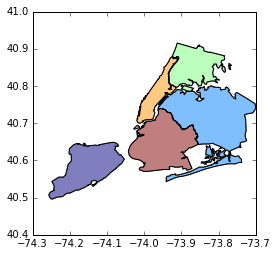

In [3]:
# view boros
boros.plot()

In [4]:
# read station data, confirm structure
stationJson = pd.read_json('CitiBike_Stations.json')
stationJson.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 507
Data columns (total 2 columns):
executionTime      508 non-null object
stationBeanList    508 non-null object
dtypes: object(2)
memory usage: 11.9+ KB


In [5]:
# convert JSON to DataFrame 
stations = pd.DataFrame()
for i,s in enumerate(stationJson.stationBeanList):
    stations = stations.append(pd.DataFrame(s, index=[i]))
    
print stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 507
Data columns (total 18 columns):
altitude                 508 non-null object
availableBikes           508 non-null int64
availableDocks           508 non-null int64
city                     508 non-null object
id                       508 non-null int64
landMark                 508 non-null object
lastCommunicationTime    508 non-null object
latitude                 508 non-null float64
location                 508 non-null object
longitude                508 non-null float64
postalCode               508 non-null object
stAddress1               508 non-null object
stAddress2               508 non-null object
stationName              508 non-null object
statusKey                508 non-null int64
statusValue              508 non-null object
testStation              508 non-null bool
totalDocks               508 non-null int64
dtypes: bool(1), float64(2), int64(5), object(10)
memory usage: 71.9+ KB
None


In [6]:
# set up station data as GeoDataFrame
stations['geometry'] = stations.apply(lambda z: geo.geoseries.Point([z.longitude, z.latitude]), axis=1)
stations = geo.GeoDataFrame(stations) # have to reset as GeoDataFrame because geopandas is glitchy
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 508 entries, 0 to 507
Data columns (total 19 columns):
altitude                 508 non-null object
availableBikes           508 non-null int64
availableDocks           508 non-null int64
city                     508 non-null object
id                       508 non-null int64
landMark                 508 non-null object
lastCommunicationTime    508 non-null object
latitude                 508 non-null float64
location                 508 non-null object
longitude                508 non-null float64
postalCode               508 non-null object
stAddress1               508 non-null object
stAddress2               508 non-null object
stationName              508 non-null object
statusKey                508 non-null int64
statusValue              508 non-null object
testStation              508 non-null bool
totalDocks               508 non-null int64
geometry                 508 non-null object
dtypes: bool(1), float64(2), int64(5)

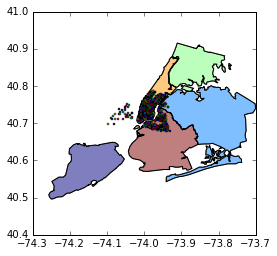

In [7]:
# check map of stations on top of boroughs
boros.plot()
stations.plot()

In [8]:
# flag stations by borough - ignore NJ cluster as we're looking at E. River bridge(s)
stations['boro'] = ''
for i, s in stations.iterrows():
    sInB = ''
    for b, boro in boros.iterrows():
        isin = s['geometry'].within(boro.geometry)
        if (isin):
            sInB = boro.Borough
    stations['boro'].iat[i] = sInB
    
stations.boro.unique() # check matched station boroughs

array([u'MN', u'BK', u'QN', ''], dtype=object)

In [9]:
# and read in June CitiBike data
citibike = pd.read_csv('201506-citibike-tripdata.csv')
print citibike.info() # check metadata

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941219 entries, 0 to 941218
Data columns (total 15 columns):
tripduration               941219 non-null int64
starttime                  941219 non-null object
stoptime                   941219 non-null object
start station id           941219 non-null int64
start station name         941219 non-null object
start station latitude     941219 non-null float64
start station longitude    941219 non-null float64
end station id             941219 non-null int64
end station name           941219 non-null object
end station latitude       941219 non-null float64
end station longitude      941219 non-null float64
bikeid                     941219 non-null int64
usertype                   941219 non-null object
birth year                 810827 non-null float64
gender                     941219 non-null int64
dtypes: float64(5), int64(5), object(5)
memory usage: 114.9+ MB
None


In [10]:
# select out just id and boro for merge to trip data
stationBoros = pd.DataFrame(stations[['boro', 'id']])
stationBoros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508 entries, 0 to 507
Data columns (total 2 columns):
boro    508 non-null object
id      508 non-null int64
dtypes: int64(1), object(1)
memory usage: 11.9+ KB


In [11]:
# join on start station id and make start station boro column
citibike = pd.merge(citibike, stationBoros, left_on='start station id', right_on='id', how='left')
citibike['start_boro'] = citibike.boro
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941219 entries, 0 to 941218
Data columns (total 18 columns):
tripduration               941219 non-null int64
starttime                  941219 non-null object
stoptime                   941219 non-null object
start station id           941219 non-null int64
start station name         941219 non-null object
start station latitude     941219 non-null float64
start station longitude    941219 non-null float64
end station id             941219 non-null int64
end station name           941219 non-null object
end station latitude       941219 non-null float64
end station longitude      941219 non-null float64
bikeid                     941219 non-null int64
usertype                   941219 non-null object
birth year                 810827 non-null float64
gender                     941219 non-null int64
boro                       932947 non-null object
id                         932947 non-null float64
start_boro                 932947 non-

In [12]:
# clean up dataframe
citibike.drop(citibike.loc[:,['boro', 'id']], axis=1, inplace=True)
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941219 entries, 0 to 941218
Data columns (total 16 columns):
tripduration               941219 non-null int64
starttime                  941219 non-null object
stoptime                   941219 non-null object
start station id           941219 non-null int64
start station name         941219 non-null object
start station latitude     941219 non-null float64
start station longitude    941219 non-null float64
end station id             941219 non-null int64
end station name           941219 non-null object
end station latitude       941219 non-null float64
end station longitude      941219 non-null float64
bikeid                     941219 non-null int64
usertype                   941219 non-null object
birth year                 810827 non-null float64
gender                     941219 non-null int64
start_boro                 932947 non-null object
dtypes: float64(5), int64(5), object(6)
memory usage: 122.1+ MB


In [ ]:
# add end station boro
citibike = pd.merge(citibike, stationBoros, left_on='end station id', right_on='id', how='left')
# citibike['end_boro'] = citibike.boro
citibike.info()

In [13]:
# add end station boro
citibike = pd.merge(citibike, stationBoros, left_on='end station id', right_on='id', how='left')
citibike['end_boro'] = citibike.boro
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941219 entries, 0 to 941218
Data columns (total 19 columns):
tripduration               941219 non-null int64
starttime                  941219 non-null object
stoptime                   941219 non-null object
start station id           941219 non-null int64
start station name         941219 non-null object
start station latitude     941219 non-null float64
start station longitude    941219 non-null float64
end station id             941219 non-null int64
end station name           941219 non-null object
end station latitude       941219 non-null float64
end station longitude      941219 non-null float64
bikeid                     941219 non-null int64
usertype                   941219 non-null object
birth year                 810827 non-null float64
gender                     941219 non-null int64
start_boro                 932947 non-null object
boro                       932430 non-null object
id                         932430 non-n

In [14]:
# clean up dataframe
citibike.drop(citibike.loc[:,['boro', 'id']], axis=1, inplace=True)
citibike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941219 entries, 0 to 941218
Data columns (total 17 columns):
tripduration               941219 non-null int64
starttime                  941219 non-null object
stoptime                   941219 non-null object
start station id           941219 non-null int64
start station name         941219 non-null object
start station latitude     941219 non-null float64
start station longitude    941219 non-null float64
end station id             941219 non-null int64
end station name           941219 non-null object
end station latitude       941219 non-null float64
end station longitude      941219 non-null float64
bikeid                     941219 non-null int64
usertype                   941219 non-null object
birth year                 810827 non-null float64
gender                     941219 non-null int64
start_boro                 932947 non-null object
end_boro                   932430 non-null object
dtypes: float64(5), int64(5), object(7)

In [15]:
# create flag for if trip crosses river ('MN' <-> 'BK'); there should be a faster way to do this...
citibike['crossed_eastriver'] = citibike.apply(lambda z: 'yes' 
                                               if ((z.start_boro=='MN' and z.end_boro=='BK') or 
                                                   (z.start_boro=='BK' and z.end_boro=='MN'))
                                              else 'no', axis=1)
# count number of trips that cross or do not cross e. river
print citibike.groupby('crossed_eastriver').size() # rough count in QGIS = 38,360, here = 37,246; difference?
# and reprint dataframe info to see it all again
citibike.info()

crossed_eastriver
no     903973
yes     37246
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 941219 entries, 0 to 941218
Data columns (total 18 columns):
tripduration               941219 non-null int64
starttime                  941219 non-null object
stoptime                   941219 non-null object
start station id           941219 non-null int64
start station name         941219 non-null object
start station latitude     941219 non-null float64
start station longitude    941219 non-null float64
end station id             941219 non-null int64
end station name           941219 non-null object
end station latitude       941219 non-null float64
end station longitude      941219 non-null float64
bikeid                     941219 non-null int64
usertype                   941219 non-null object
birth year                 810827 non-null float64
gender                     941219 non-null int64
start_boro                 932947 non-null object
end_boro                   932

In [17]:
# write out station boroughs, and updated citibike dataframes
stationBoros.to_csv('./station_boroughs.csv', sep=',')
citibike.to_csv('./201506-trips-wCrossings-1004.csv', sep=',')

In [19]:
37246.0 / 903973

0.04120255804100344